# TFM. Modelo predictivo llamadas Call Center
## MVP

## Importacion de librerias 

In [1]:
#import pymssql
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import datetime

pd.options.display.max_columns = None

### Importacion de los datos de envios por oficinas

In [2]:
df_shippings = pd.read_csv('data/shippings.csv', low_memory=False)

In [3]:
df_shippings['Franquicia destino'].unique()

array([4800, 4802, 4803, 4806, 4810])

In [4]:
df = df_shippings[ (df_shippings['Franquicia destino']==4800) ]
#df = df_shippings
df.columns

Index(['Unnamed: 0', 'Fecha envío', 'Número envío', 'Id. Fiscal',
       'Nombre Comercial', 'Código servicio', 'Nombre Rem', 'Población Rem',
       'CP Rem', 'Nombre vía Rem', 'Nombre', 'Población', 'Código postal',
       'Nombre vía', 'Total bultos', 'Franquicia origen', 'Franquicia destino',
       'Total', 'Estado', 'Tipo anomalía', 'Motivo', 'Importe Total'],
      dtype='object')

In [5]:
df = df.iloc[:, [1,5,12,14,15,16]]
df

,Fecha envío,Código servicio,Código postal,Total bultos,Franquicia origen,Franquicia destino
0,01/01/2020,Urgente 12,07011,1,636,4800
1,01/01/2020,Económico,07003,2,640,4800
2,01/01/2020,Económico,07001,1,642,4800
3,01/01/2020,Urgente 10,07012,1,679,4800
4,01/01/2020,E-commerce,07003,1,2638,4800
...,...,...,...,...,...,...
164142,02/02/2021,Urgente 19,07160,1,4810,4800
164143,02/02/2021,Urgente 19,07014,1,4810,4800
164144,02/02/2021,Urgente 12,07014,1,4810,4800
164145,02/02/2021,Urgente 19,07181,1,4810,4800


In [6]:
df['Fecha envío'] = pd.to_datetime(df['Fecha envío'])

In [7]:
def updateDate(s):
    envio24h = ['Urgente 8:30', 'Urgente 10','Urgente 12','Urgente 14','Urgente 19', \
               'Urgente 8:30 expedición', 'Urgente 10 expedición','Urgente 12 expedición', \
               'Urgente 14 expedición','Urgente 19 expedición','Urgente hoy','Burofax', \
               'Documentos 14','Mascotas','Bag 14','Bag 19','Express documentos']
    envio48h = ['Económico','E-commerce','Mrw economy (ecopaq)','Retorno canje']
    maritimo = ['Marítimo baleares']
    
    nDate = np.nan
    ## Arreglar los 24H
    if s['Código servicio'] in envio24h:
        nDate = s['Fecha envío'] + datetime.timedelta(days=1)
    elif s['Código servicio'] in envio48h:
        nDate = s['Fecha envío'] + datetime.timedelta(days=2)
    else:
        nDate = s['Fecha envío'] + datetime.timedelta(days=4)
    
    if nDate.isoweekday() == 7:
        nDate = nDate + datetime.timedelta(days=1)
    elif nDate.isoweekday() == 6:
        nDate = nDate + datetime.timedelta(days=2)
        
    return nDate

In [8]:
df['xDate'] = df.apply(updateDate, axis=1)

In [9]:
df[df['xDate'].isnull()]

,Fecha envío,Código servicio,Código postal,Total bultos,Franquicia origen,Franquicia destino,xDate


In [10]:
df['Fecha envío'] =  pd.to_datetime(df['xDate']).astype('str')

In [11]:
#Filtro Fecha
#df = df[ df['Fecha envío'] == '2020-02-18' ]

In [12]:
df['Código servicio'].unique()

array(['Urgente 12', 'Económico', 'Urgente 10', 'E-commerce',
       'Urgente 19', 'Mascotas', 'Marítimo baleares', 'Urgente 14',
       'Urgente 19 expedición', 'Urgente 12 expedición', 'Urgente 8:30',
       'Burofax', 'Retorno albarán', 'Bag 14', 'Urgente 10 expedición',
       'Urgente hoy', 'Documentos 14', 'Bag 19',
       'Urgente 8:30 expedición', 'Mrw economy (ecopaq)',
       'Urgente 14 expedición', 'Express documentos', 'Retorno canje'],
      dtype=object)

In [13]:
train = df[['Fecha envío','Código servicio','Franquicia origen','Código postal']]
train.reset_index(inplace=True)
train = train[['Fecha envío','Código servicio','Franquicia origen','Código postal']]
train['total'] = 1

In [14]:
train.head()

,Fecha envío,Código servicio,Franquicia origen,Código postal,total
0,2020-01-02,Urgente 12,636,07011,1
1,2020-01-03,Económico,640,07003,1
2,2020-01-03,Económico,642,07001,1
3,2020-01-02,Urgente 10,679,07012,1
4,2020-01-03,E-commerce,2638,07003,1


In [15]:
train['Franquicia origen'] = train['Franquicia origen'].apply(str)
train['Código postal'] = train['Código postal'].apply(str)

In [16]:
encoder = OneHotEncoder(handle_unknown='ignore')
enc = train[['Código servicio']]

In [17]:
encoder.fit(enc.values.reshape(-1,1))
encoder.categories_

[array(['Bag 14', 'Bag 19', 'Burofax', 'Documentos 14', 'E-commerce',
        'Económico', 'Express documentos', 'Marítimo baleares', 'Mascotas',
        'Mrw economy (ecopaq)', 'Retorno albarán', 'Retorno canje',
        'Urgente 10', 'Urgente 10 expedición', 'Urgente 12',
        'Urgente 12 expedición', 'Urgente 14', 'Urgente 14 expedición',
        'Urgente 19', 'Urgente 19 expedición', 'Urgente 8:30',
        'Urgente 8:30 expedición', 'Urgente hoy'], dtype=object)]

In [18]:
encoded = encoder.transform(enc.values.reshape(-1,1))
encoded_df = pd.DataFrame(encoded.todense())
encoded_df.columns = encoder.categories_[0]

In [19]:
train = pd.concat([train,encoded_df], axis=1)

In [20]:
#encoder = OneHotEncoder(handle_unknown='ignore')
#enc = train[['Franquicia origen']]
#encoder.fit(enc.values.reshape(-1,1))
#encoded = encoder.transform(enc.values.reshape(-1,1))
#encoded_df = pd.DataFrame(encoded.todense())
#encoded_df.columns = encoder.categories_[0]

In [21]:
#train = pd.concat([train,encoded_df], axis=1)

In [22]:
#encoder = OneHotEncoder(handle_unknown='ignore')
#enc = train[['Código postal']]
#encoder.fit(enc.values.reshape(-1,1))
#encoded = encoder.transform(enc.values.reshape(-1,1))
#encoded_df = pd.DataFrame(encoded.todense())
#encoded_df.columns = encoder.categories_[0]

In [23]:
#train = pd.concat([train,encoded_df], axis=1)

In [24]:
train.drop(columns=['Código servicio','Franquicia origen','Código postal'], inplace=True)

In [25]:
train = train.groupby(['Fecha envío']).sum()

In [26]:
train.head()

,total,Bag 14,Bag 19,Burofax,Documentos 14,E-commerce,Económico,Express documentos,Marítimo baleares,Mascotas,Mrw economy (ecopaq),Retorno albarán,Retorno canje,Urgente 10,Urgente 10 expedición,Urgente 12,Urgente 12 expedición,Urgente 14,Urgente 14 expedición,Urgente 19,Urgente 19 expedición,Urgente 8:30,Urgente 8:30 expedición,Urgente hoy
Fecha envío,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-01-03,146,0.0,0.0,0.0,0.0,34.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0
2020-01-06,441,0.0,0.0,0.0,0.0,207.0,66.0,0.0,54.0,1.0,0.0,0.0,0.0,16.0,1.0,58.0,10.0,0.0,0.0,23.0,5.0,0.0,0.0,0.0
2020-01-07,202,0.0,0.0,1.0,0.0,8.0,3.0,0.0,91.0,4.0,0.0,0.0,0.0,13.0,1.0,48.0,2.0,0.0,0.0,27.0,4.0,0.0,0.0,0.0
2020-01-08,771,0.0,0.0,1.0,0.0,431.0,51.0,0.0,246.0,0.0,0.0,0.0,0.0,10.0,1.0,13.0,0.0,0.0,0.0,15.0,2.0,1.0,0.0,0.0


### Importacion de los datos de llamadas por oficinas

In [27]:
df_calls = pd.read_csv('data/calls.csv')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
df_calls.columns

Index(['Unnamed: 0', 'idTransaccion', 'tInicio', 'tFinal', 'estado',
       'tProximoContacto', 'tReplanificacion', 'nTAdmin', 'nTAdminExcedido',
       'nTQ', 'idSujeto', 'sIdOriginal', 'sNombreCliente', 'sApellido1Cliente',
       'sApellido2Cliente', 'sTelefonoCliente', 'idServicio', 'idCampanya',
       'idAgente', 'idSegmento', 'sNombreSegmento', 'sAtributoSegmento',
       'sFiltroSegmento', 'sDescripcionFinal', 'sDescripcionFinal.1',
       'idFinal', 'sDescripcionFinal.2', 'sFiltroFinal', 'tActualizado',
       'tCreacion', 'nOrigenTransaccion'],
      dtype='object')

In [29]:
df_calls['sTelefonoCliente'][df_calls['sTelefonoCliente'].isnull() == True] 

0         NaN
1         NaN
1634      NaN
21123     NaN
25623     NaN
25659     NaN
61933     NaN
71745     NaN
71786     NaN
82418     NaN
82704     NaN
101157    NaN
108384    NaN
111725    NaN
129667    NaN
133307    NaN
135941    NaN
138519    NaN
142555    NaN
Name: sTelefonoCliente, dtype: object

In [30]:
df_calls = df_calls[df_calls['sTelefonoCliente'].notna()]

In [31]:
df_calls = df_calls[['tCreacion','tInicio','tFinal','sTelefonoCliente','idCampanya']]
df_calls

,tCreacion,tInicio,tFinal,sTelefonoCliente,idCampanya
2,2020-03-01 13:42:29.567,NaN,2020-03-01 13:42:44.647,918298287,100000021.0
3,2020-03-01 18:48:01.543,NaN,2020-03-01 18:48:08.430,664401666,100000021.0
4,2020-03-02 02:46:55.637,NaN,2020-03-02 02:47:07.040,918298287,100000015.0
5,2020-03-02 07:28:57.743,NaN,2020-03-02 07:29:06.180,653312359,100000021.0
6,2020-03-02 08:05:45.267,2020-03-02 08:06:37.973,2020-03-02 08:08:33.807,971886546,100000021.0
...,...,...,...,...,...
185650,2021-03-01 18:23:09.127,NaN,2021-03-01 18:23:20.437,618612573,100000021.0
185651,2021-03-01 18:41:53.330,NaN,2021-03-01 18:42:04.347,636294460,100000021.0
185652,2021-03-01 18:42:09.820,NaN,2021-03-01 18:42:24.097,636294460,100000021.0
185653,2021-03-01 18:54:21.400,NaN,2021-03-01 18:54:40.957,916425282,100000021.0


In [32]:
df_calls['tCreacion'] = pd.to_datetime(df_calls['tCreacion'])
df_calls['tInicio'] = pd.to_datetime(df_calls['tInicio'])
df_calls['tFinal'] = pd.to_datetime(df_calls['tFinal'])

df_calls['Date'] = df_calls['tCreacion'].dt.date
df_calls['Date'] = df_calls['Date'].astype('str')

df_calls['dateCreacion'] = df_calls['tCreacion'].dt.date
df_calls['dateCreacion'] = df_calls['dateCreacion'].astype('str')

df_calls['dateInicio'] = df_calls['tInicio'].dt.date
df_calls['dateInicio'] = df_calls['dateInicio'].astype('str') 

In [33]:
df_calls

,tCreacion,tInicio,tFinal,sTelefonoCliente,idCampanya,Date,dateCreacion,dateInicio
2,2020-03-01 13:42:29.567,NaT,2020-03-01 13:42:44.647,918298287,100000021.0,2020-03-01,2020-03-01,NaT
3,2020-03-01 18:48:01.543,NaT,2020-03-01 18:48:08.430,664401666,100000021.0,2020-03-01,2020-03-01,NaT
4,2020-03-02 02:46:55.637,NaT,2020-03-02 02:47:07.040,918298287,100000015.0,2020-03-02,2020-03-02,NaT
5,2020-03-02 07:28:57.743,NaT,2020-03-02 07:29:06.180,653312359,100000021.0,2020-03-02,2020-03-02,NaT
6,2020-03-02 08:05:45.267,2020-03-02 08:06:37.973,2020-03-02 08:08:33.807,971886546,100000021.0,2020-03-02,2020-03-02,2020-03-02
...,...,...,...,...,...,...,...,...
185650,2021-03-01 18:23:09.127,NaT,2021-03-01 18:23:20.437,618612573,100000021.0,2021-03-01,2021-03-01,NaT
185651,2021-03-01 18:41:53.330,NaT,2021-03-01 18:42:04.347,636294460,100000021.0,2021-03-01,2021-03-01,NaT
185652,2021-03-01 18:42:09.820,NaT,2021-03-01 18:42:24.097,636294460,100000021.0,2021-03-01,2021-03-01,NaT
185653,2021-03-01 18:54:21.400,NaT,2021-03-01 18:54:40.957,916425282,100000021.0,2021-03-01,2021-03-01,NaT


In [34]:
df_calls = df_calls[['Date','dateCreacion','sTelefonoCliente','idCampanya']]

In [35]:
df_calls.drop_duplicates(inplace=True)

<ipython-input-35-194b5f777100>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calls.drop_duplicates(inplace=True)


### Analisis Datos

In [36]:
df_calls = df_calls[ df_calls['idCampanya'] == 100000015.0 ]

In [37]:
df_calls = df_calls.groupby('Date').count()
df_calls = df_calls[['dateCreacion']]
df_calls = df_calls[df_calls.dateCreacion > 20]

In [38]:
df_explore = pd.concat([train, df_calls], axis=1).reset_index()
df_explore.dropna(inplace=True)
df_explore.head()

,index,total,Bag 14,Bag 19,Burofax,Documentos 14,E-commerce,Económico,Express documentos,Marítimo baleares,Mascotas,Mrw economy (ecopaq),Retorno albarán,Retorno canje,Urgente 10,Urgente 10 expedición,Urgente 12,Urgente 12 expedición,Urgente 14,Urgente 14 expedición,Urgente 19,Urgente 19 expedición,Urgente 8:30,Urgente 8:30 expedición,Urgente hoy,dateCreacion
42,2020-03-02,1784.0,2.0,1.0,5.0,1.0,297.0,221.0,0.0,980.0,2.0,0.0,6.0,0.0,60.0,5.0,100.0,24.0,1.0,0.0,41.0,34.0,3.0,1.0,0.0,140.0
43,2020-03-03,640.0,0.0,0.0,2.0,1.0,140.0,70.0,0.0,186.0,8.0,0.0,0.0,0.0,52.0,1.0,102.0,21.0,1.0,0.0,33.0,17.0,5.0,1.0,0.0,135.0
44,2020-03-04,737.0,0.0,0.0,3.0,0.0,340.0,127.0,0.0,38.0,5.0,0.0,0.0,0.0,44.0,5.0,83.0,18.0,1.0,0.0,54.0,17.0,1.0,1.0,0.0,118.0
45,2020-03-05,709.0,0.0,0.0,0.0,0.0,234.0,117.0,0.0,279.0,0.0,0.0,3.0,0.0,10.0,1.0,25.0,4.0,1.0,0.0,21.0,13.0,0.0,1.0,0.0,128.0
46,2020-03-06,712.0,0.0,0.0,0.0,0.0,137.0,40.0,0.0,518.0,0.0,0.0,0.0,0.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.0


In [39]:
df_explore.sum()

index                      2020-03-022020-03-032020-03-042020-03-052020-0...
total                                                               125847.0
Bag 14                                                                  11.0
Bag 19                                                                  15.0
Burofax                                                                299.0
Documentos 14                                                           17.0
E-commerce                                                           33318.0
Económico                                                             9531.0
Express documentos                                                       4.0
Marítimo baleares                                                    63731.0
Mascotas                                                               574.0
Mrw economy (ecopaq)                                                    13.0
Retorno albarán                                                        113.0

In [40]:
df_explore.dateCreacion.describe()

count    234.000000
mean     106.705128
std       75.379744
min       23.000000
25%       59.000000
50%       78.500000
75%      119.000000
max      374.000000
Name: dateCreacion, dtype: float64

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

(array([54., 93., 38., 11.,  7., 10.,  4.,  8.,  4.,  5.]),
 array([ 23. ,  58.1,  93.2, 128.3, 163.4, 198.5, 233.6, 268.7, 303.8,
        338.9, 374. ]),
 <a list of 10 Patch objects>)

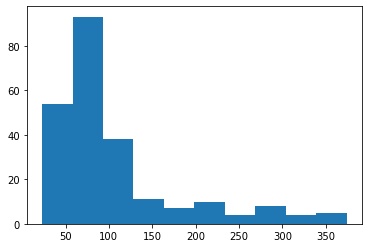

In [42]:
plt.hist(df_explore['dateCreacion'])

In [43]:
#df_subset = df_explore.iloc[:,[0,1]]
#df_subtotal = df_explore.iloc[:,-1]
#df_subtotal = pd.concat([df_subset, df_subtotal], axis=1)
#df_subtotal.head()

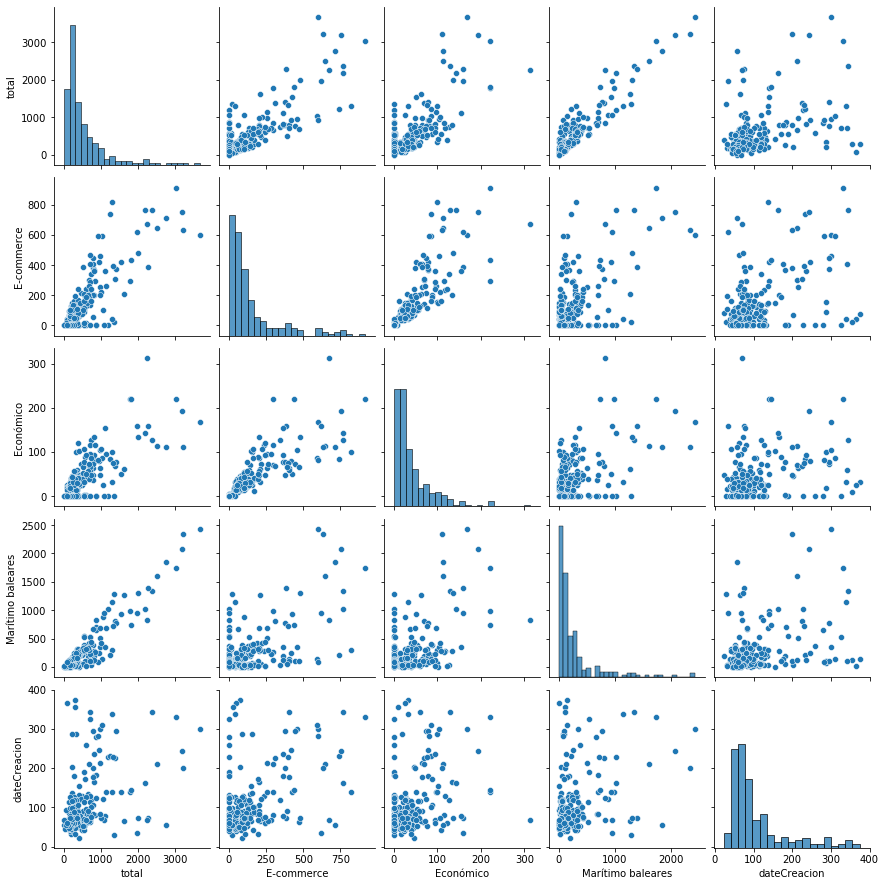

In [44]:
sns.pairplot(df_explore.loc[:,['total','E-commerce','Económico','Marítimo baleares','dateCreacion']]);

In [45]:
x = np.array(df_explore['index'])
envios = np.array(df_explore['total'])
llamadas = np.array(df_explore['dateCreacion'])

envio24h = np.array(df_explore['Urgente 8:30'] + df_explore['Urgente 10'] + df_explore['Urgente 12'] + \
    df_explore['Urgente 14'] + df_explore['Urgente 19'] + df_explore['Urgente 8:30 expedición'] + \
    df_explore['Urgente 10 expedición'] + df_explore['Urgente 12 expedición'] + \
    df_explore['Urgente 19 expedición'] + df_explore['Burofax'] + \
    df_explore['Mascotas'])

envio48h = np.array(df_explore['Económico'] + df_explore['E-commerce'])

minoritarios =  np.array(df_explore['Bag 14'] + df_explore['Bag 19'] + df_explore['Express documentos'] + \
    df_explore['Documentos 14'] + df_explore['Urgente hoy'] +  df_explore['Urgente 14 expedición'] + \
    df_explore['Retorno canje'] + df_explore['Mrw economy (ecopaq)'])

maritimo = np.array(df_explore['Marítimo baleares'])

In [46]:
def normalizar2(Xs, datos, llamadas):
    mask = datos == 0
    x = np.delete(Xs, mask)
    d1 = np.delete(datos, mask)
    d2 = np.delete(llamadas, mask)
    d1 = np.log(d1)
    d2 = np.log(d2)
    
    return x, d1, d2

def normalizar(Xs, datos, llamadas):
    mask = datos == 0
    x = np.delete(Xs, mask)
    d1 = np.delete(datos, mask)
    d2 = np.delete(llamadas, mask)
    
    return x, d1, d2

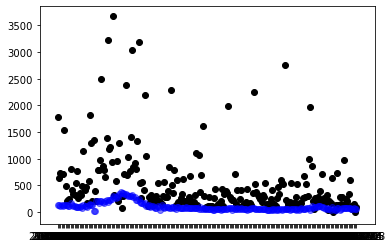

In [47]:
Xs, ys1, ys2 = normalizar(x, envios, llamadas)
plt.scatter(Xs, ys1, c='black')
plt.scatter(Xs, ys2, c='blue', alpha=.5);

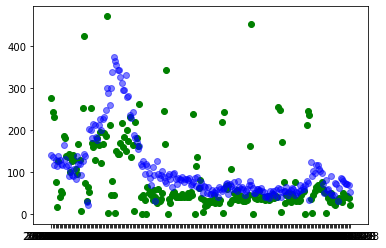

In [48]:
Xs, ys1, ys2 = normalizar(x, envio24h, llamadas)
plt.scatter(Xs, ys1, c='green')
plt.scatter(Xs, ys2, c='blue', alpha=.5);

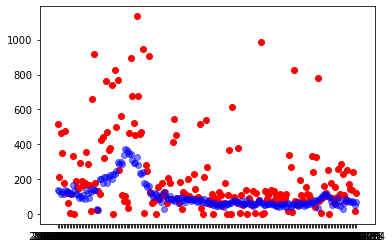

In [49]:
Xs, ys1, ys2 = normalizar(x, envio48h, llamadas)
plt.scatter(Xs, ys1, c='red')
plt.scatter(Xs, ys2, c='blue', alpha=.5);

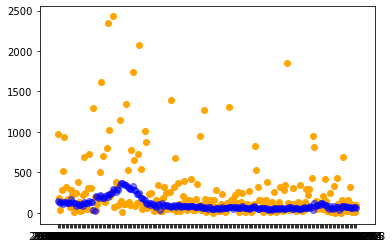

In [50]:
Xs, ys1, ys2 = normalizar(x, maritimo, llamadas)
plt.scatter(Xs, ys1, c='orange')
plt.scatter(Xs, ys2, c='blue', alpha=.5);

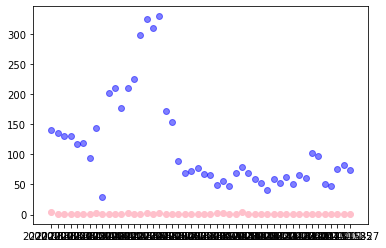

In [51]:
Xs, ys1, ys2 = normalizar(x, minoritarios, llamadas)
plt.scatter(Xs, ys1, c='pink')
plt.scatter(Xs, ys2, c='blue', alpha=.5);

## Modelo

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [53]:
reg = LinearRegression()

In [54]:
X = df_explore.iloc[:,1:-1]
y = df_explore['dateCreacion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [55]:
reg.fit(X_train,y_train)

LinearRegression()

In [56]:
y_pred = reg.predict(X_test)

In [57]:
mean_absolute_error(y_test, y_pred)

39.10114948039812

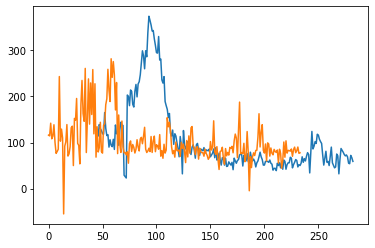

In [58]:
plt.plot(df_explore.iloc[:,-1])
plt.plot(reg.predict(df_explore.iloc[:,1:-1]))

In [59]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [60]:
reg_gs = GridSearchCV(KNeighborsRegressor(),
                        param_grid={"n_neighbors":np.arange(3,50)})

In [61]:
reg_gs.fit(X,y)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [62]:
reg_gs.best_params_, reg_gs.best_score_

({'n_neighbors': 14}, -7.010527454331917)

In [63]:
regk = KNeighborsRegressor(n_neighbors=3)

In [64]:
regk.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=3)

In [65]:
y_predk = regk.predict(X_test)

In [66]:
#MAE
mean_absolute_error(y_test, y_predk)

40.801418439716315

In [67]:
cross_val_score(regk,X,y,scoring='neg_mean_absolute_error').mean()

-52.78803576934937